# Introduction to Machine Learning for the Built Environment: Energy Consumption Forecasting

This notebook is adapted from Dr. Clayton Miller. It uses the Building Data Genome Project data set to analyze electrical meter data from non-residential buildings.

## Import relevant python packages

Let's use the electrical meter data to create clusters of typical load profiles for analysis. First we can load our conventional packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

Next let's load all the packages we will need for  analysis

In [2]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime

# Electricity Prediction for Measurement and Verification

Prediction is a common machine learning (ML) technique used on building energy consumption data. This process is valuable for anomaly detection, load profile-based building control and measurement and verification procedures. 

The graphic below comes from the IPMVP to show how prediction can be used for M&V to calculate how much energy **would have** been consumed if an energy savings intervention had not been implemented. 



## Prediction for Measurement and Verification

![alt text](https://raw.githubusercontent.com/buds-lab/the-building-data-genome-project/master/docs/edx-graphics/EDX-ML-ScikitLearn-3.png)

There is an open publication that gives more information on how prediction in this realm can be approached: https://www.mdpi.com/2504-4990/1/3/56

There is an entire Kaggle Machine Learning competition also focused on this application: https://www.kaggle.com/c/ashrae-energy-prediction



## Load electricity data and weather data

First we can load the data from the BDG in the same as our previous weather analysis influence notebook from the Construction Phase videos

In [3]:
elec_all_data = pd.read_csv("../input/buildingdatagenomeproject2/electricity_cleaned.csv", index_col='timestamp', parse_dates=True)

In [4]:
elec_all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 1578 entries, Panther_parking_Lorriane to Mouse_science_Micheal
dtypes: float64(1578)
memory usage: 211.3 MB


In [5]:
buildingname = 'Panther_office_Hannah'

In [6]:
office_example_prediction_data = pd.DataFrame(elec_all_data[buildingname].truncate(before='2017-01-01')).fillna(method='ffill')

In [7]:
office_example_prediction_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


<AxesSubplot:xlabel='timestamp'>

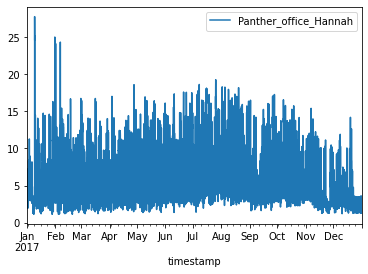

In [8]:
office_example_prediction_data.plot()

In [9]:
weather_data = pd.read_csv("../input/buildingdatagenomeproject2/weather.csv", index_col='timestamp', parse_dates=True)

In [10]:
weather_data_site = weather_data[weather_data.site_id == 'Panther'].truncate(before='2017-01-01')

In [11]:
weather_data_site.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   site_id         8760 non-null   object 
 1   airTemperature  8760 non-null   float64
 2   cloudCoverage   5047 non-null   float64
 3   dewTemperature  8760 non-null   float64
 4   precipDepth1HR  8752 non-null   float64
 5   precipDepth6HR  329 non-null    float64
 6   seaLvlPressure  8522 non-null   float64
 7   windDirection   8511 non-null   float64
 8   windSpeed       8760 non-null   float64
dtypes: float64(8), object(1)
memory usage: 684.4+ KB


In [12]:
weather_hourly = weather_data_site.resample("H").mean()
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')

In [13]:
temperature = weather_hourly_nooutlier_nogaps["airTemperature"]

<AxesSubplot:xlabel='timestamp'>

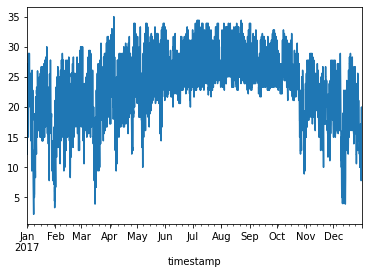

In [14]:
temperature.plot()

## Create Train and Test Datasets

The model is given a set of data that will be used to **train** the model to predict a specific objectice. In this case, we will use a few simple time series features as well as outdoor air temperature to predict how much energy a building uses.

For this demonstration, we will use three months of data from April, May, and June to prediction July.

In [15]:
training_months = [4,5,6]
test_months = [7]

We can divide the data set by using the `datetime index` of the data frame and a function known as `.isin` to extract the months for the model

In [16]:
trainingdata = office_example_prediction_data[office_example_prediction_data.index.month.isin(training_months)]
testdata = office_example_prediction_data[office_example_prediction_data.index.month.isin(test_months)]

In [17]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2184 entries, 2017-04-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  2184 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [18]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2017-07-01 00:00:00 to 2017-07-31 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


We can extract the training input data features that will go into the model and the training **label** data which is what are are targeting to predict. 

## Encoding Categorical Variables 

We use the pandas `.get_dummies()` function to change the temporal variables of *time of day* and *day of week* into categories that the model can use more effectively. This process is known as [enconding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [19]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour), 
                                     pd.get_dummies(trainingdata.index.dayofweek), 
                                     pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()


In [20]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,0,1,2,3,4,5,6,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,21.7
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,21.0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18.9
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,20.6
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,21.0


## Train a K-Neighbor Model

This model was chosen after following the process in the cheat sheet until a model that worked and provided good results was found.

In [21]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values));


In [22]:
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())



## Use the Model to predict for the *Test* period

Then the model is given the `test_features` from the period which we want to predict. We can then merge those results and see how the model did

In [23]:
predictions = model.predict(test_features)

In [24]:
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, index=testdata.index)], axis=1)

In [25]:
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [26]:
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2017-07-01 00:00:00,5.3370,5.75910
2017-07-01 01:00:00,3.8547,6.02898
2017-07-01 02:00:00,5.5751,4.39686
2017-07-01 03:00:00,4.1248,4.23180
2017-07-01 04:00:00,3.3497,4.03858


<AxesSubplot:xlabel='timestamp'>

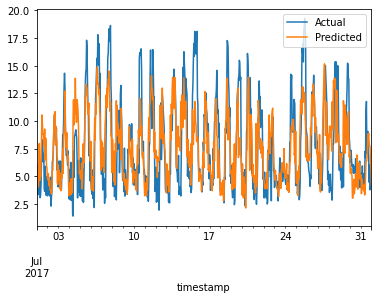

In [27]:
predicted_vs_actual.plot()

In [28]:
trainingdata.columns = ["Actual"]

In [29]:
predicted_vs_actual_plus_training = pd.concat([trainingdata, predicted_vs_actual], sort=True)

<AxesSubplot:xlabel='timestamp'>

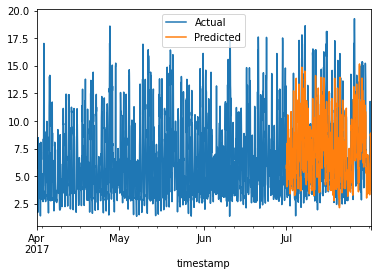

In [30]:
predicted_vs_actual_plus_training.plot()

## Evaluation metrics

In order to understand quanitatively how the model performed, we can use various evaluation metrics to understand how well the model compared to reality. 

In this situation, let's use the error metric [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) 

In [31]:
# Calculate the absolute errors
errors = abs(predicted_vs_actual['Predicted'] - predicted_vs_actual['Actual'])
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / predicted_vs_actual['Actual']))

In [32]:
MAPE

34.22379683897996